In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Simulating carrier noise?

Let's try simulating some carrier noise and see if we can get it to look a bit like what we see in the experiment.

## First: just a sine wave

In [6]:
T = 1000 # we need a long time to get good spectral resolution
N = T * 50 # this will set our nyquist frequency

t = np.linspace(0,T,N)
v1 = np.cos(2*np.pi*t) # 1 secon period

(0, 5)

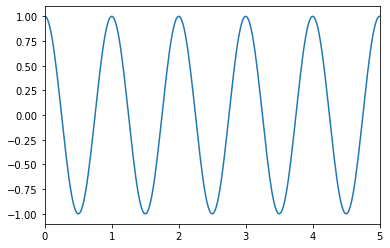

In [7]:
plt.plot(t,v1)
plt.xlim(0,5)

(0.975, 1.025)

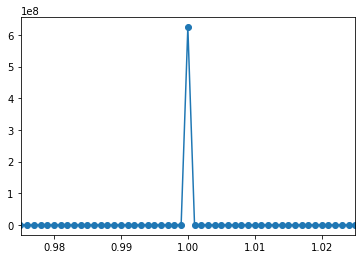

In [8]:
v1t = np.fft.fft(v1)

# For plotting, let's shift them
v1ts = np.fft.fftshift(v1t)
fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

plt.plot(fs,np.abs(v1ts)**2,"o-")
span = 0.05
plt.xlim(1-span/2,1+span/2)

Of course, the spectral resolution of our FFT depends on the lenth of our time trace.

Actually, very useful to look at a spectrum on a log scale.

(100.0, 2000000000.0)

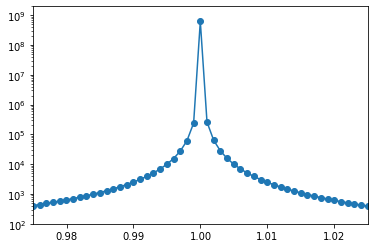

In [9]:
plt.plot(fs,np.abs(v1ts)**2,"o-")
span = 0.05
plt.xlim(1-span/2,1+span/2)
plt.yscale('log')
plt.ylim(1e2,2e9)

Hmmm...not a perfect delta function! Why? Good question...

Probably due to either the fininte sampling  rate, or due to the finite time trace length. Let's investigate. 

In [10]:
def plot_power_spectrum(T,N_per_osc):
    N = T * N_per_osc # this will set our nyquist frequency
    t = np.linspace(0,T,N)
    v = np.cos(2*np.pi*t) # 1 secon period
    vt = np.fft.fft(v)

    # For plotting, let's shift them
    vts = np.fft.fftshift(vt)
    fs = np.fft.fftshift(np.fft.fftfreq(len(v), d=t[1]))
    
    # Calculate power spectrum and normalise it
    power = np.abs(vts)**2
    power /= max(power)
    
    span = 0.1
    n1 = np.where(fs >= 1-span/2)[0][0]
    n2 = np.where(fs >= 1+span/2)[0][0]
    
    plt.plot(fs[n1:n2],power[n1:n2],"o-",label=f"T = {T}, N_per_osc = {N_per_osc}")
    plt.yscale('log')

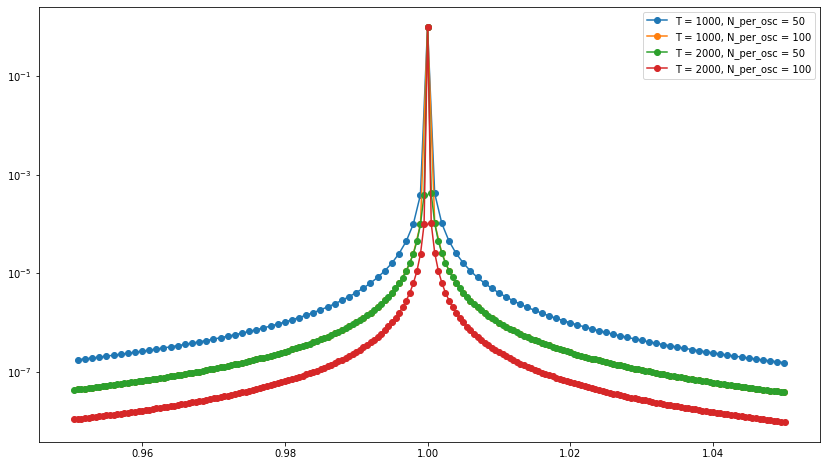

In [12]:
plt.subplots(figsize=(14,8))
plot_power_spectrum(1000,50)
plot_power_spectrum(1000,100)
plot_power_spectrum(2000,50)
plot_power_spectrum(2000,100)
plt.legend()

Interesting: Increasing the sampling rate or the total trace time decreases the tails of the peak in the same way. 

Naively, if I apply the typical physics logic, there would be an uncertainty in the frequency determined  by the total trace time T, and which should not depend on the sampling rate, whereas here the tail amplitude does depend on the sampling rate. 

Furthermore, the FFT does use implicit periodic boundary  conditions, so the answer should actually be exact...? 

If I understand correctly, the time domain waveform I've created should be an exact basis state of the Fourier basis (well, an exact superposition of two with positive and negative frequency). So why is this not a delta function? 

Anton had the answer: I had one point too many! `endpoint` is a handy parameter for `np.linspace`:

In [1]:
def plot_power_spectrum_fixed(T,N_per_osc):
    N = T * N_per_osc # this will set our nyquist frequency
    t = np.linspace(0,T,N,endpoint=False)
    v = np.cos(2*np.pi*t) # 1 secon period
    vt = np.fft.fft(v)

    # For plotting, let's shift them
    vts = np.fft.fftshift(vt)
    fs = np.fft.fftshift(np.fft.fftfreq(len(v), d=t[1]))
    
    # Calculate power spectrum and normalise it
    power = np.abs(vts)**2
    power /= max(power)
    
    span = 0.1
    n1 = np.where(fs >= 1-span/2)[0][0]
    n2 = np.where(fs >= 1+span/2)[0][0]
    
    plt.plot(fs[n1:n2],power[n1:n2],"o-",label=f"T = {T}, N_per_osc = {N_per_osc}")
    plt.yscale('log')

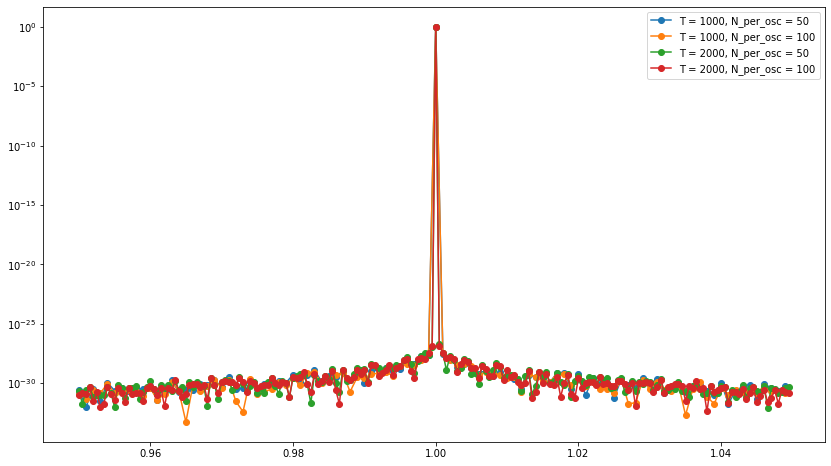

In [13]:
plt.subplots(figsize=(14,8))
plot_power_spectrum_fixed(1000,50)
plot_power_spectrum_fixed(1000,100)
plot_power_spectrum_fixed(2000,50)
plot_power_spectrum_fixed(2000,100)
plt.legend()

## Now: try amplitude noise

In the units above, let's make a amplitude noise spectrum that has a cutoff of 20 mHz. 

The filter function is (OK, now I have to check my own lecture notes...): 

$$
\frac{1}{i\omega/\omega_0 + 1}
$$

In [6]:
amp = np.random.normal(loc=1,scale=0.2, size=N)

cutoff = 0.02
f = np.fft.fftfreq(N,d=t[1])
amp_t = np.fft.fft(amp)
low_pass = 1/(1j*(f/cutoff)+1)
amp_fil = np.real(np.fft.ifft(amp_t*low_pass))

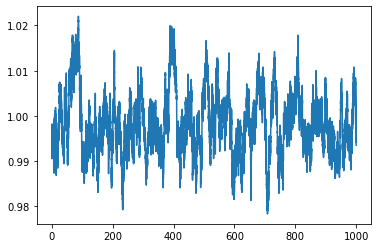

In [7]:
plt.plot(t,amp_fil)

In [8]:
v2 = amp_fil*v1

(-1.03, -0.97)

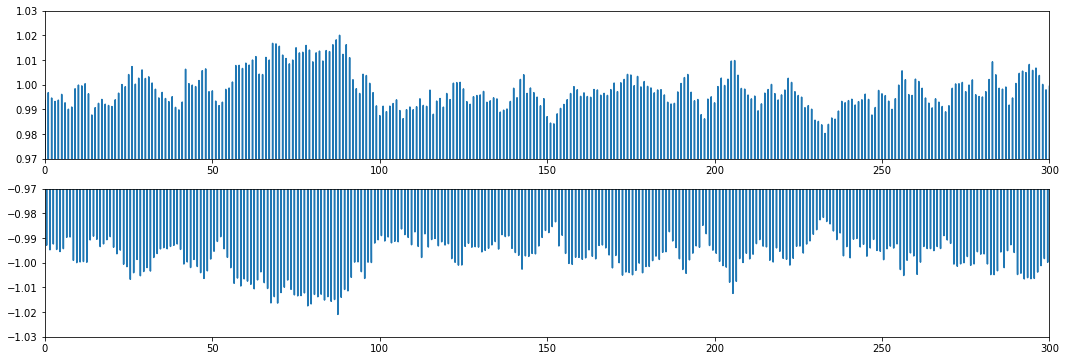

In [9]:
plt.subplots(figsize=(18,6))
plt.subplot(211)
plt.plot(t,v2)
plt.xlim(0,300)
dy = 0.03
plt.ylim(1-dy,1+dy)
plt.subplot(212)
plt.plot(t,v2)
plt.xlim(0,300)
plt.ylim(-1-dy,-1+dy)

Yep, looks like amplitude noise to me :)

Let's check the FFT:

(10, 2000000000.0)

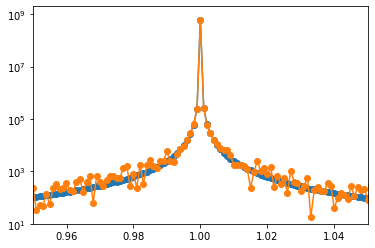

In [11]:
vt2 = np.fft.fft(v2)

# For plotting, let's shift them
vt2s = np.fft.fftshift(vt2)
fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

plt.plot(fs,np.abs(v1ts)**2,"o-")
plt.plot(fs,np.abs(vt2s)**2,"o-")
span = 0.1
plt.xlim(1-span/2,1+span/2)
plt.yscale('log')
plt.ylim(10,2e9)

OK, it looks noisy. But do I see the cutoff somewhere? Should I see the cutoff somewhere?

## Sanity check: Amplitude modulation

Modulate the amplitude sinusoidally. This should give sidebands. Right?

In [57]:
v3 = (1+0.1*np.sin(2*np.pi*t*0.02))*v1

(0, 100)

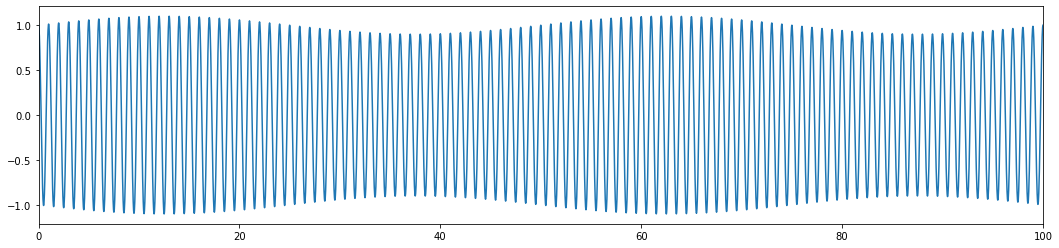

In [58]:
plt.subplots(figsize=(18,4))
plt.plot(t,v3)
plt.xlim(0,100)

In [125]:
def plot_spec(vp):
    vpt = np.fft.fft(vp)
    
    # For plotting, let's shift them
    vpts = np.fft.fftshift(vpt)
    fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

    plt.plot(fs,np.abs(v1ts)**2,"o-")
    plt.plot(fs,np.abs(vpts)**2,"o-")
    span = 0.1
    plt.xlim(1-span/2,1+span/2)
    plt.yscale('log')
    plt.ylim(10,2e9)

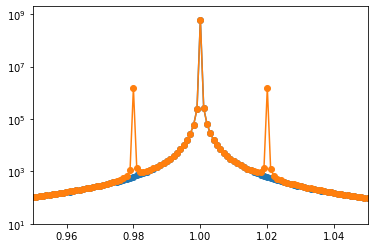

In [126]:
plot_spec(v3)

OK, this works. Good, I'm not going completely insane! :)

But it raises the question: how do I get a "noise shoulder"? 

I think I need to take *many* realisations of the noise and then average together the resulting power spectra. This is a bit what is done in power spectrum estimation techniques like `scipy.welch`:

https://en.wikipedia.org/wiki/Spectral_density_estimation

Probably running it for 100 times longe time trace then using `scipy.welch` properly would give a good spectral estimation. For another night

## Phase modulation

Let's try phase modulation: 

$$
\cos(\omega t + \cos(\omega_m t))
$$


In [127]:
phase = np.cos(2*np.pi*0.02*t)*5e-2
v4 = np.cos(2*np.pi*t + phase)

(0, 20)

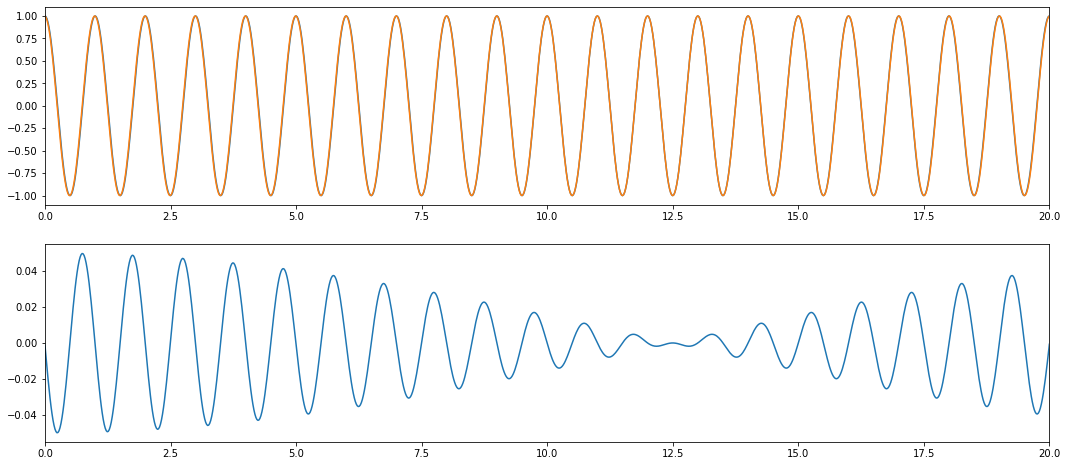

In [128]:
off=0
plt.subplots(figsize=(18,8))
plt.subplot(211)
plt.plot(t,v1)
plt.plot(t,v4)
plt.xlim(off,off+20)
plt.subplot(212)
plt.plot(t,v4-v1)
plt.xlim(off,off+20)

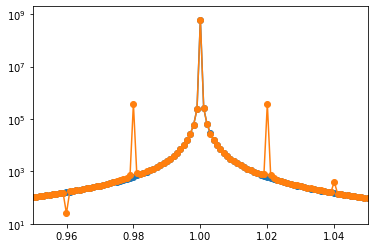

In [129]:
plot_spec(v4)